# Лабораторная работа 2
## Семантическая сегментация

Попов Илья 406

### Задание
0. Гиперпараметры (модель, оптимизатор и его параметры, шедулер и имя функции ошибки) для экспериментов конфигурировать через класс-контейнер (может быть `namedtuple`,`dataclass`, `pydantic.Model` или просто класс без методов (кроме __init__).
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в clearml табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив. Таблицы, графики и т.д. Можно забрать из clearml).
* При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять.




In [2]:
import torch, torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

## Датасет
VOC (Pascal Visual Object Classes) - это набор данных, который содержит изображения различных объектов, размеченных по классам. Каждое изображение сопровождается маской сегментации, где каждый пиксель на изображении имеет метку класса объекта, к которому он принадлежит.

Для обработки датасета VOC мы используем библиотеку OpenCV для работы с изображениями и их масками. Мы также используем класс VOCSegmentation из библиотеки torchvision для доступа к данным датасета.

Переменная VOC_CLASSES содержит список классов объектов, которые присутствуют в датасете VOC, а переменная VOC_COLORMAP содержит соответствующие цвета для каждого класса в формате RGB. Эти данные позволяют нам преобразовывать маски сегментации в нужный формат для обучения модели.

In [3]:
import cv2
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

Класс PascalVOCSearchDataset наследует функционал от VOCSegmentation для работы с датасетом Pascal VOC. Метод init инициализирует объекты класса, принимая параметры пути к данным, набора изображений, опции загрузки и преобразования. Метод convert_to_segmentation_mask преобразует маски изображений из формата Pascal VOC в формат, необходимый для обучения модели. Метод _getitem возвращает изображение и соответствующую маску из датасета после применения преобразований.

In [4]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

Используем Albumentations для создания аугментаций для обучающих данных. Для обучающей выборки мы применяем случайные изменения яркости и контраста, обрезаем или изменяем размер изображения. Для валидационной выборки мы также приводим изображения к нужному размеру, но без аугментаций, только с обрезкой по центру.

In [5]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, CenterCrop
augs = Compose([
    PadIfNeeded(448,448),
    RandomBrightnessContrast(),
    OneOf([
        RandomCrop(256,256, p=0.2),
        RandomSizedCrop((224,448),256,256)
    ], p =1)
])

val_augs = Compose([
    PadIfNeeded(448, 448),
    CenterCrop(256, 256)
])

In [6]:
train = PascalVOCSearchDataset(
    root='.',
    image_set="train",
    download=True,
    transform=augs
)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [7]:
val = PascalVOCSearchDataset(
    root='.',
    image_set="val",
    download=True,
    transform=val_augs
)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


#### Пример картинки

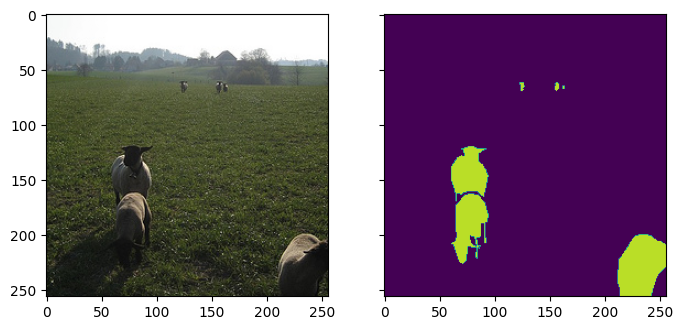

In [8]:
img, lbl = train[1000]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,6))
ax = ax.ravel()

ax[0].imshow(img.permute(1, 2, 0))
lbl_plot = ax[1].imshow(lbl.argmax(0), vmax=19)
plt.show()

## 0. Гиперпараметры
Cодержит гиперпараметры модели, оптимизатора, планировщика и функции потерь, которые будут использоваться в обучении.

In [9]:
from dataclasses import dataclass
from typing import Any, Optional

@dataclass
class Hyperparams:
    model:            str
    model_params:     dict[str, Any]
    optimizer:        str
    optimizer_params: dict[str, Any]
    scheduler:        str
    scheduler_params: dict[str, Any]
    loss_fn:          str
    loss_fn_params:   dict[str, Any]

## 1. Валидация и трейн
Функция validation() оценивает модель на валидационном наборе данных. Она вычисляет среднюю потерю и среднее значение метрики MIoU для всех образцов в валидационном наборе. Для этого она использует предсказания модели и истинные метки изображений.

In [10]:
def validation():
  cur_val_loss = 0
  cur_val_miou = 0
  val_samples_num = 0
  with torch.no_grad():
      for images, labels in val_dataloader:
          val_samples_num += len(images)
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)['out']
          loss = criterion(preds, labels)
          cur_val_loss += loss.detach().cpu().item()
          cur_val_miou += MIoU(labels.detach().cpu(), preds.detach().cpu()).sum()
  return cur_val_loss / val_samples_num, cur_val_miou / val_samples_num

Функция training() отвечает за обучение модели. Она переводит модель в режим обучения, проходит по обучающему набору данных, вычисляет потери и метрики на каждом батче, осуществляет обратное распространение ошибки и обновление весов модели. В конце возвращает средние потери и метрики на всем обучающем наборе.

In [11]:
def training():
  model.train()

  cur_train_loss = 0
  cur_train_miou = 0
  train_samples_num = 0

  for images, labels in train_dataloader:
      train_samples_num += len(images)

      images = images.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)

      preds = model(images)['out']
      loss = criterion(preds, labels)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      cur_train_loss += loss.detach().cpu().item()
      cur_train_miou += MIoU(labels.detach().cpu(), preds.detach().cpu()).sum()

  return cur_train_loss / train_samples_num, cur_train_miou / train_samples_num


## 2. Метрика IoU
Функция IoU() вычисляет метрику IoU для каждого класса в каждом батче данных. Она преобразует форму истинных и предсказанных меток, затем вычисляет пересечение и объединение между ними, и возвращает IoU для каждого класса в каждом батче.

In [12]:
def IoU(real, pred):

    batch_size = real.shape[0]
    classes_num = real.shape[1]

    real = real.reshape(batch_size, classes_num, -1).long()
    pred = (
        F.one_hot(pred.argmax(axis=1), num_classes=classes_num)
        .permute(0, 3, 1, 2)
        .reshape(batch_size, classes_num, -1)
        .long()
    )

    intersection = (real & pred).sum(axis=-1)
    union = (real | pred).sum(axis=-1)
    iou = intersection / union
    return iou

## 3. Метрика MIoU
Функция MIoU() вычисляет среднюю метрику IoU для всех классов по всем батчам в истинных и предсказанных метках. Она использует ранее определенную функцию IoU() для вычисления IoU и затем вычисляет среднее значение IoU для каждого класса.

In [13]:
def MIoU(real, pred):
    iou = IoU(real, pred)
    return iou.nanmean(axis=1)

## 4. Обучение
Используется предобученная модель deeplabv3_mobilenet_v3_large для сегментации. Оптимизатор - AdamW, с коэффициентом обучения 3e-5 и параметром weight_decay 1e-5. В качестве функции потерь используется CrossEntropyLoss с параметром label_smoothing 1e-5. Также используется StepLR планировщик с параметрами step_size 1 и gamma 0.5. Модель и оптимизатор инициализируются с учетом этих параметров. Данные загружаются с помощью DataLoader, используя размеры батчей 64 для обучающего набора и 32 для валидационного. Обучение модели происходит на GPU, если он доступен, в противном случае - на CPU. Обучение планируется на 3 эпохи, а также отслеживаются потери и метрика IoU для обучающего и валидационного наборов данных.

In [14]:
hp = Hyperparams(
    model="deeplabv3_mobilenet_v3_large",
    model_params={"weights": True, "num_classes": len(VOC_CLASSES), "progress": True},
    optimizer="AdamW",
    optimizer_params={"lr": 3e-5, "weight_decay": 1e-5},
    scheduler="StepLR",
    scheduler_params={"step_size": 1, "gamma": 0.5},
    loss_fn="CrossEntropyLoss",
    loss_fn_params={"label_smoothing": 1e-5}
)

In [15]:
model = torchvision.models.segmentation.__dict__[hp.model](**hp.model_params)
optimizer = torch.optim.__dict__[hp.optimizer](model.parameters(), **hp.optimizer_params)
criterion = torch.nn.__dict__[hp.loss_fn](**hp.loss_fn_params)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val, batch_size=32, num_workers=2, pin_memory=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 3

train_losses = []
val_losses = []
train_miou = []
val_miou = []

model = model.to(device)

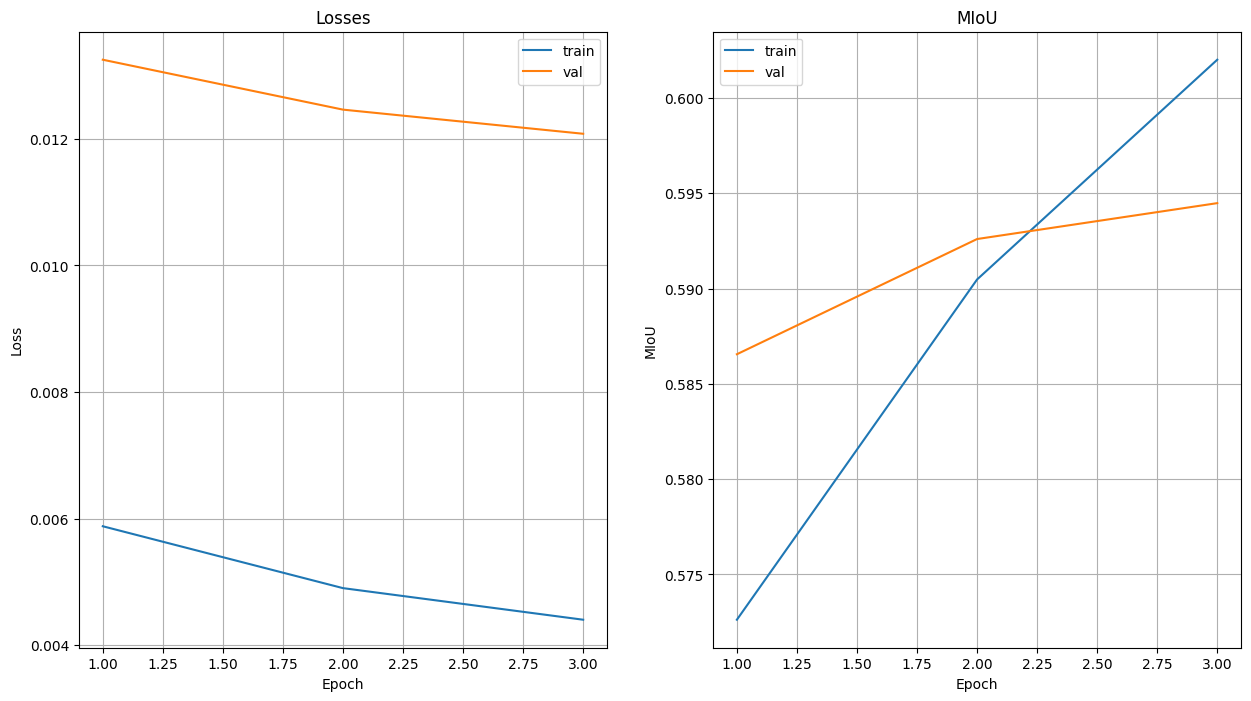

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='train')
plt.plot(range(1, epochs+1), val_losses, label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_miou, label='train')
plt.plot(range(1, epochs+1), val_miou, label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MIoU')
plt.title('MIoU')

plt.show()

## 5. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%.

Для каждого изображения и метки в валидационном DataLoader'е модель используется для получения предсказаний. Затем вычисляется метрика IoU и MIoU между истинными и предсказанными метками. Результаты сохраняются в переменные val_iou и val_miou. Если переменные пусты, они инициализируются значениями метрик для текущего батча данных, в противном случае к ним добавляются результаты для текущего батча данных.

In [19]:
val_iou = None
val_miou = None

with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)['out']
        iou = IoU(labels.detach().cpu(), preds.detach().cpu())
        miou = MIoU(labels.detach().cpu(), preds.detach().cpu())

        if val_iou is None:
            val_iou = iou.detach().cpu()
            val_miou = miou.detach().cpu()
        else:
            val_iou = torch.cat((val_iou, iou.detach().cpu()), dim=0)
            val_miou = torch.cat((val_miou, miou.detach().cpu()), dim=0)

  0%|          | 0/46 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 46/46 [07:49<00:00, 10.21s/it]


In [ ]:
val_miou.shape

torch.Size([1449])


Тут разбиватся изображения, метки и предсказания на три класса на основе значений MIoU. Сначала вычисляются квантили MIoU для 90%, 75-85%, и 45-55% уровней. Затем происходит итерация по валидационному DataLoader'у для каждого изображения и его соответствующей метки. Значение MIoU для каждого изображения проверяется на принадлежность к заданным квантилям. Изображения, метки и предсказания с высоким MIoU сохраняются для каждого класса. Когда для каждого класса набрано необходимое количество изображений, процесс завершается.

In [ ]:
q_90 = torch.quantile(val_miou, 0.9).item()
q_85 = torch.quantile(val_miou, 0.85).item()
q_75 = torch.quantile(val_miou, 0.75).item()
q_55 = torch.quantile(val_miou, 0.55).item()
q_45 = torch.quantile(val_miou, 0.45).item()

In [ ]:
pictures_class1 = None
labels_class1 = None
preds_class1 = None

pictures_class2 = None
labels_class2 = None
preds_class2 = None

pictures_class3 = None
labels_class3 = None
preds_class3 = None

In [ ]:
count_image = 3

pictures_class = [pictures_class1, pictures_class2, pictures_class3]
labels_class = [labels_class1, labels_class2, labels_class3]
preds_class = [preds_class1, preds_class2, preds_class3]
border = [[q_90, 1], [q_75, q_85], [q_45, q_55]]
with torch.no_grad():
  for images, labels in val_dataloader:
    for i in range(len(val_miou)):
      cur_miou = val_miou[i].item()

      for j in range(len(pictures_class)):
        if cur_miou in border[j]:
          if pictures_class[j] is None:
            pictures_class[j] = images[i].detach().cpu().unsqueeze(0)
            labels_class[j] = labels[i].detach().cpu().unsqueeze(0)
            preds_class[j] = preds[i].detach().cpu().unsqueeze(0)
          elif len(pictures_class[j]) < count_image:
            pictures_class[j] = torch.cat((pictures_class[j], images[i].detach().cpu().unsqueeze(0)), dim=0)
            labels_class[j] = torch.cat((labels_class[j], labels[i].detach().cpu().unsqueeze(0)), dim=0)
            preds_class[j] = torch.cat((preds_class[j], preds[i].detach().cpu().unsqueeze(0)), dim=0)
          else:
            continue
      if pictures_class1 is not None and len(pictures_class1) == count_image \
        and pictures_class2 is not None and len(pictures_class2) == count_image \
        and pictures_class3 is not None and len(pictures_class3) == count_image:
        break

Топ 10%:

Text(0.5, 1.0, 'Real')

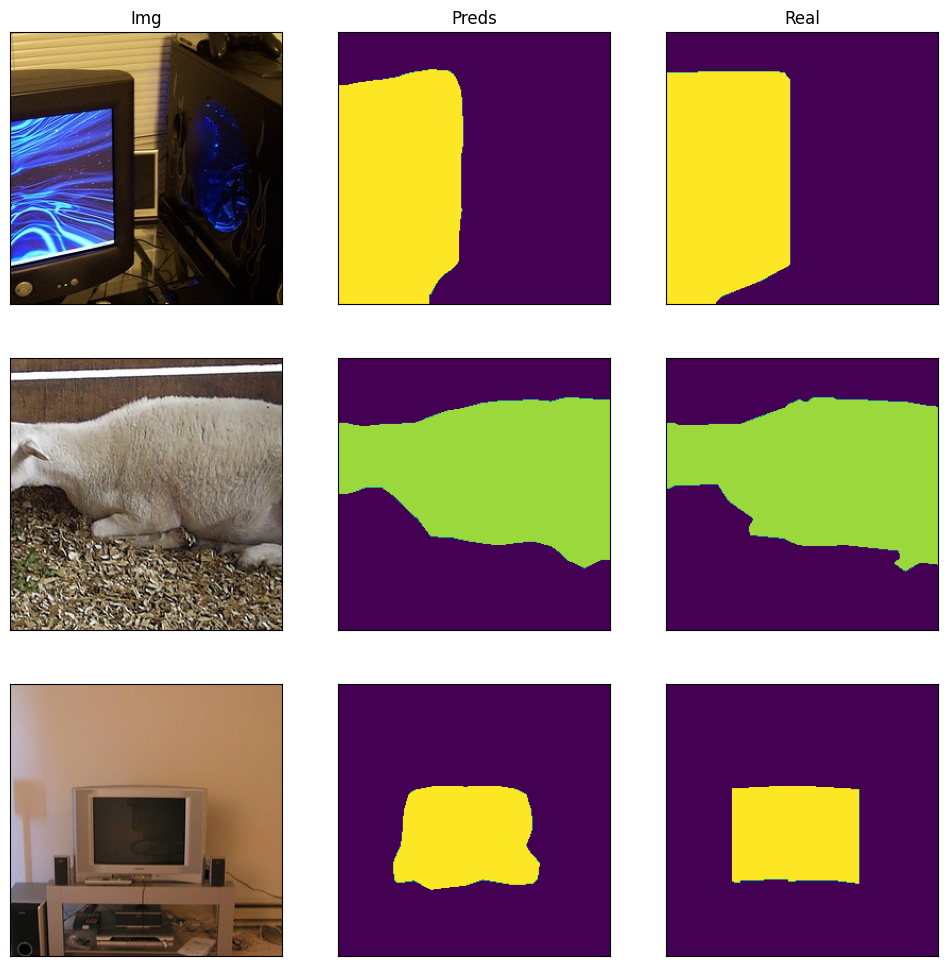

In [ ]:
fig, axes = plt.subplots(len(pictures_class1), 3, figsize=(12, len(pictures_class1)*4))

for i, (img, pred, label) in enumerate(zip(pictures_class1, preds_class1.softmax(1), labels_class1)):
    axes[i, 0].imshow(img.permute(1, 2, 0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

Топ 15-25%:

Text(0.5, 1.0, 'Real')

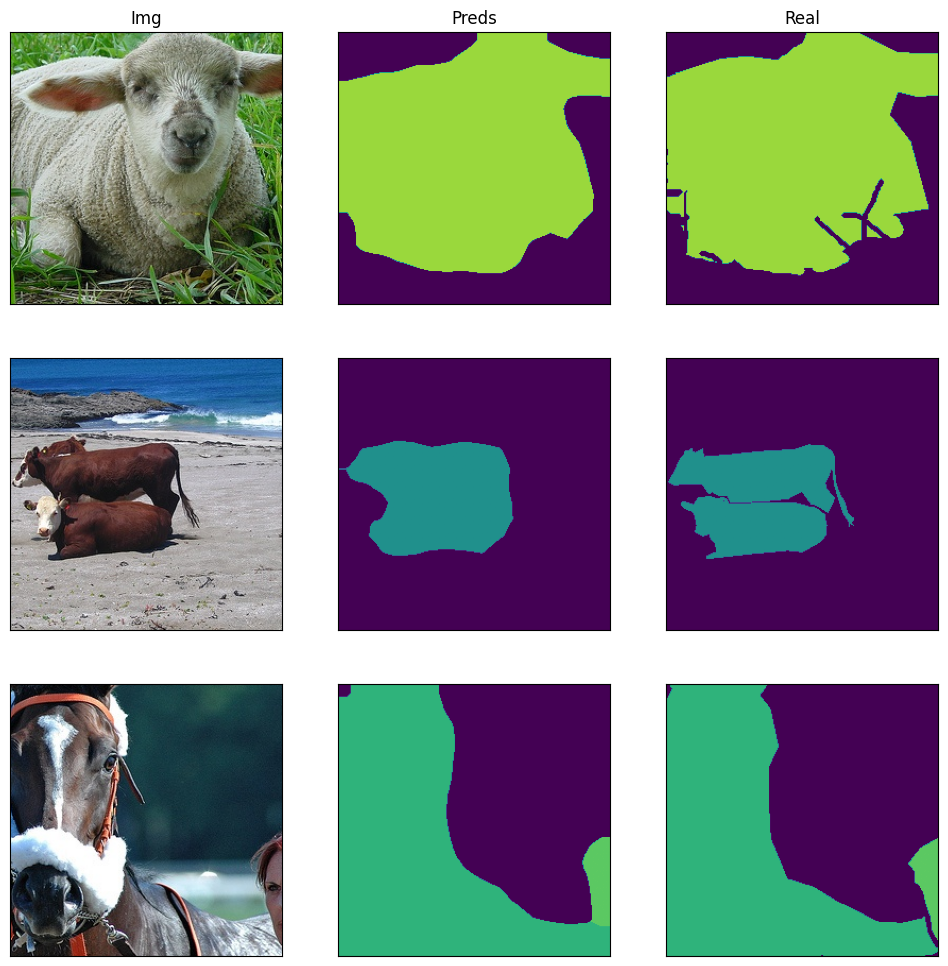

In [ ]:
fig, axes = plt.subplots(len(pictures_class2), 3, figsize=(12, len(pictures_class2)*4))

for i, (img, pred, label) in enumerate(zip(pictures_class2, preds_class2.softmax(1), labels_class2)):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

Топ 45-55%:

/tmp/ipykernel_30152/2637224071.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


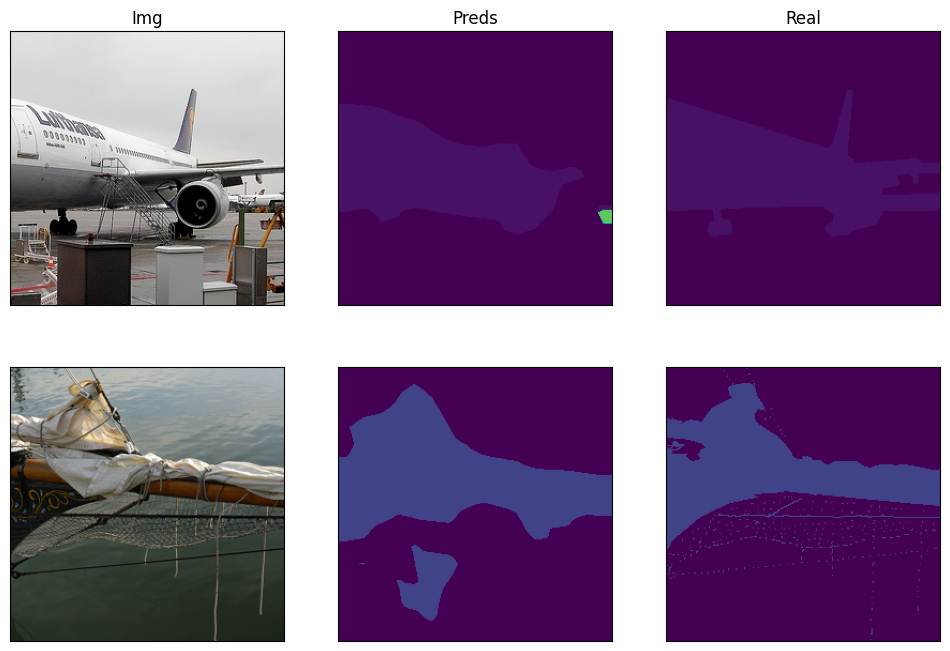

In [ ]:
fig, axes = plt.subplots(len(pictures_class[2]), 3, figsize=(12, len(pictures_class[2])*4))

for i, (img, pred, label) in enumerate(zip(pictures_class[2], preds_class[2].softmax(1), labels_class[2])):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Img')
fig.axes[1].set_title('Preds')
fig.axes[2].set_title('Real')

fig.show()

## 6. Отберём лучшую по качеству IoU картинку по трем выбранным классам.

Посмотрим на IoU в разбивке по классам и выберем 3 с самым высоким показателем

In [ ]:
class_data = dict(zip(VOC_CLASSES, val_iou.nanmean(axis=1)))
for class_name, class_iou in sorted(class_data.items(), key=lambda item: item[1], reverse=True):
  print(f'{class_name:13} {class_iou:.3f}')

tensor(0.9201)
tensor(0.8702)
tensor(0.8623)
tensor(0.8373)
tensor(0.8297)
tensor(0.8066)
tensor(0.6974)
tensor(0.6559)
tensor(0.6198)
tensor(0.6121)
tensor(0.5657)
tensor(0.5598)
tensor(0.4680)
tensor(0.4653)
tensor(0.3554)
tensor(0.3506)
tensor(0.3457)
tensor(0.3400)
tensor(0.3317)
tensor(0.3229)
tensor(0.1233)


Подходящие классы:
1.   bus
2.   sheep
3. cat



In [ ]:
val_iou

torch.Size([1449, 21])

## 7. Построим таблицу IoU в развертке по каждому классу для лучшей модели

In [ ]:
import pandas as pd
shp = val_iou.shape

pd.DataFrame(val_iou.reshape((shp[0], shp[1])).numpy(), columns=VOC_CLASSES)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,potted plant,sheep,sofa,train,tv/monitor
0,0.873774,0.80563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,0.765465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.847822,NaN
2,0.856702,NaN,NaN,NaN,0.455004,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.336376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.632406,NaN
4,0.613048,NaN,0.504637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.718614,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN
1445,0.984543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1446,0.616796,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.927794,NaN,NaN,NaN,NaN,NaN
1447,0.138470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.518344,NaN,NaN,NaN,NaN,NaN,0.212539,NaN,NaN


# Вывод

В данной работе была решена задача многоклассовой семантической сегментации на датасете Pascal VOC. Для этого использовалась предобученная сеть deeplabv3_mobilenet_large_v3. Обучение проводилось в течение 5 эпох. На валидационной выборке достигнуто значение MIoU равное 0.59. Интересно отметить, что на некоторых классах эта метрика достигает значения до 0.9, что говорит о высокой точности сегментации для этих классов, в то время как для других классов значение MIoU приближается к нулю, что может указывать на сложности в их сегментации и требует дальнейших улучшений в обучении модели.